In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# Configure Matplotlib to use LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
# Use latex font 

Text(0.5, 0, '$t$')

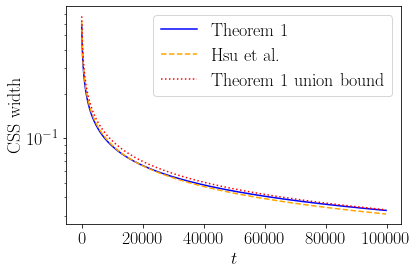

In [160]:
alpha = 0.05 
n = 100000

start = 150

css = subG_css(10, 1, n, np.log(1/alpha))
hsu_union = hsu_union_bound(10, 10, 1, n, np.log(1/alpha))
css_union = css_union_bound(10, 1, n, np.log(1/alpha))

plt.plot(css[start:], label='Theorem 1', c='blue')
plt.plot(hsu_union[start:], label='Hsu et al.', ls='--', c='orange')
plt.plot(css_union[start:], label='Theorem 1 union bound', ls=':', c='red')


plt.legend()

plt.yscale('log')
plt.ylabel('CSS width')
plt.xlabel('$t$')
#plt.xscale('log')




In [3]:
def subG_css(trSigma, lambdamax, n, r): 

    beta = np.sqrt(2*trSigma*r / lambdamax)
    lambda_num = beta + 2*r

    lambda_sum = 0 
    lambda2_sum = 0

    widths = []
    for t in range(1, n): 
        #lambda_denom = (lambdamax + trSigma/beta)*t*np.log(t+25000)*3
        lambda_denom = (lambdamax + trSigma/beta)*t*np.log(t+10e4)
        lambdat =  np.sqrt(lambda_num / lambda_denom)
        lambda_sum += lambdat
        lambda2_sum += lambdat**2/2

        width_num = lambda2_sum*(lambdamax + trSigma/beta) + beta/2 + r
        width_denom = lambda_sum
        widths.append(width_num / width_denom) 

    return widths

def Hsu_n(trSigma, trSigma2, lambdamax, n, r): 

    s = trSigma + 2*lambdamax*r + 2*np.sqrt(trSigma2*r)
    return np.sqrt(s/n)

def css_n(trSigma, lambdamax, n, r): 

    s = trSigma + 2*lambdamax*r + 2*np.sqrt(2*trSigma*lambdamax*r)
    return np.sqrt(s/n)

def css_union_bound(trSigma, lambdamax, n, r):
    
    widths = []
    for t in range(1, n): 
        width = css_n(trSigma, lambdamax, t, r + np.log(t*(t+1)))
        widths.append(width)

    return widths

def stitched_Hsu(trSigma, trSigma2, lambdamax, n, r): 

    widths = []
    for t in range(1, n): 

        # if t is a power of 2 
        if (t & (t-1)) == 0: 
            width = Hsu_n(trSigma, trSigma2, lambdamax, t/2, r + 2*np.log(np.log2(t)) + 1/2)
            widths.append(width)
        else: 
            widths.append(widths[-1])

    return widths

def hsu_union_bound(trSigma, trSigma2, lambdamax, n, r):
    
    widths = []
    for t in range(1, n): 
        width = Hsu_n(trSigma, trSigma2, lambdamax, t, r + np.log(t*(t+1)))
        widths.append(width)

    return widths

def stitched_subG_css(trSigma, lambdamax, n, r):

    widths = []
    epoch= 0 
    for t in range(1, n): 
        # if t is a power of 2 
        if (t & (t-1)) == 0: 
            # New epoch 
            epoch += 1 
            r_e = np.log((epoch + 1)**2 * 1.645) + r
            beta_e = np.sqrt(r_e * trSigma / lambdamax) * 2
            lambda_e = beta_e / np.sqrt(trSigma*2**epoch)

        width_num = t*lambda_e**2*(lambdamax + trSigma/beta_e)/2 + beta_e/2 + r_e
        width_denom = t*lambda_e
        widths.append(width_num / width_denom)

    return widths

def stitched_explicit(trSigma, lambdamax, n, r): 
    widths = []

    for t in range(1, n): 

        term1 = 1.21 * np.sqrt(trSigma/t) 
        term2 = 1.682*np.sqrt(lambdamax*(r + np.log(1.65) + np.log(np.log2(t) + 1)) / t)

        widths.append(term1 + term2)   

    return widths 


/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_41536/1384412686.py:49: RuntimeWarning: divide by zero encountered in log
  width = Hsu_n(trSigma, trSigma2, lambdamax, t/2, r + 2*np.log(np.log2(t)) + 1/2)
/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_41536/1384412686.py:25: RuntimeWarning: invalid value encountered in sqrt
  s = trSigma + 2*lambdamax*r + 2*np.sqrt(trSigma2*r)


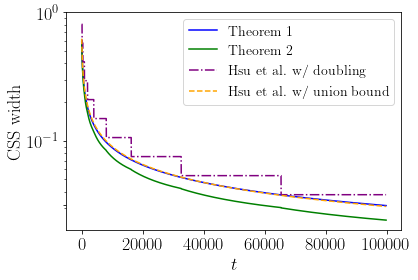

In [4]:
alpha = 0.05 
n = 100000

start = 150

css = subG_css(10, 1, n, np.log(1/alpha))
stitched_css = stitched_subG_css(10, 1, n, np.log(1/alpha))
stitched_hsu = stitched_Hsu(10, 10, 1, n, np.log(1/alpha))
hsu_union = hsu_union_bound(10, 10, 1, n, np.log(1/alpha))
# css_union = css_union_bound(10, 1, n, np.log(1/alpha))

#css_explicit = stitched_explicit(10, 1, n, np.log(1/alpha))

plt.plot(css[start:], label='Theorem 1', c='blue')
plt.plot(stitched_css[start:], label='Theorem 2', ls='-', c='green')
plt.plot(stitched_hsu[start:], label='Hsu et al. w/ doubling', ls='-.', c='purple')
plt.plot(hsu_union[start:], label='Hsu et al. w/ union bound', ls='--', c='orange')
#plt.plot(css_explicit[start:], label='Stitched explicit', ls=':', c='red')


plt.legend(fontsize=14)
plt.yscale('log')
plt.ylabel('CSS width')
plt.xlabel('$t$')
plt.yticks([10**-1.5, 10**-1, 10**0])

plt.savefig('figures/subG.png', dpi=300, bbox_inches='tight')



/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_42546/1384412686.py:49: RuntimeWarning: divide by zero encountered in log
  width = Hsu_n(trSigma, trSigma2, lambdamax, t/2, r + 2*np.log(np.log2(t)) + 1/2)
/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_42546/1384412686.py:25: RuntimeWarning: invalid value encountered in sqrt
  s = trSigma + 2*lambdamax*r + 2*np.sqrt(trSigma2*r)


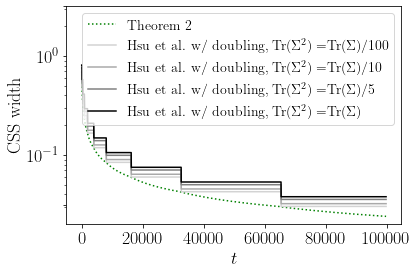

In [20]:
alpha = 0.05 
n = 100000
start = 150

stitched_css = stitched_subG_css(10, 1, n, np.log(1/alpha))

stitched_Hsu_p1 = stitched_Hsu(10, 0.1, 1, n, np.log(1/alpha))
stitched_hsu_1 = stitched_Hsu(10, 1, 1, n, np.log(1/alpha))
stitched_hsu_5 = stitched_Hsu(10, 5, 1, n, np.log(1/alpha))
stitched_hsu_10 = stitched_Hsu(10, 10, 1, n, np.log(1/alpha))

# plt.plot(css[start:], label='Theorem 1', c='red')
plt.plot(stitched_css[start:], label='Theorem 2', ls=':', c='green')
plt.plot(stitched_Hsu_p1[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)/100$', ls='-', c='lightgray')
plt.plot(stitched_hsu_1[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)/10$', ls='-', c='darkgray')
plt.plot(stitched_hsu_5[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)/5$', ls='-', c='gray')
plt.plot(stitched_hsu_10[start:], label='Hsu et al. w/ doubling, Tr($\Sigma^2)= $Tr($\Sigma)$', ls='-', c='black')


plt.yscale('log')
plt.legend(fontsize=14)
plt.ylabel('CSS width')
plt.xlabel('$t$')
plt.yticks([10**-1.5, 10**-1, 10**0, 10**0.5])

plt.savefig('figures/subG_doubling.png', dpi=300, bbox_inches='tight')

